# Project 2：NASA Data Acquisation, Visualization, and Analysis

In [1]:
# The code makes sure that once there is change in the 'src/' folder, the
# change will be automatically reloaded in the notebook.
import pandas as pd
%reload_ext autoreload
%autoreload 2
%aimport src

### Task 1: Understanding the NASA API and Data Collection

- Register for a NASA API key and understand the different types of data that the API provides.
- Run the Python script below to fetch data about **Near Earth Objects (NEOs)** from the NASA API for a years data.
- Extract and understand the different pieces of data provided for each NEO.

In [2]:
import requests
import time
from datetime import datetime, timedelta
from getpass import getpass

# Set your NASA API KEY, this step asks you to enter your API KEY.
# (The input box may be float in the top on your editor.)
api_key = getpass()

In [3]:
# Set the start and end dates for the data you want to fetch
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = start_date + timedelta(days=365)  # 1 year later

# Initialize a list to store the data
data = []

# Fetch data from the NASA API 7 days at a time
# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"
# You can look into the example query in the link below to see what the data look like:
# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY
current_date = start_date
while current_date < end_date:
    next_date = min(current_date + timedelta(days=7), end_date)
    response = requests.get(f'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strftime("%Y-%m-%d")}&api_key={api_key}')
    data.append(response.json())
    current_date = next_date
    time.sleep(1)  # To avoid hitting the rate limit

# Now 'data' contains the NEO data for the 1-year period


In [4]:
# Check the date coverage of your data.
dates_contained_in_data = []
for d in data:
    dates_contained_in_data += list(d['near_earth_objects'].keys())

print(sorted(dates_contained_in_data))

['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-15', '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-22', '2022-01-22', '2022-01-23', '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-29', '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05', '2022-02-05', '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-12', '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-19', '2022-02-19', '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-26', '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04', '2022

In [5]:
from src.utils import get_a_random_chunk_property

In [6]:
get_a_random_chunk_property(data)

date: 2022-11-19
NEO name: (2014 WQ202)
id: 3698842


For the remaining tasks, you have to organize the data as pd.DataFrame so as to suit the specific need in each task. This part may require a considerably amount of efforts, which is normal in data science and analytics works.

### Task 2: Data Analysis

- Calculate the average size of the NEOs for each day.
- Determine the proportion of NEOs that are potentially hazardous.
- Find the NEO with the closest approach distance for each day.
- Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

In [20]:
# Write your code
"""
Here we flatten the data such that all the week dimension is removed
"""
concat_data = []
for week in data:
    for day in week["near_earth_objects"]:
        for neo in week["near_earth_objects"][day]:
            concat_data.append(neo)


In [84]:
"""
Now we create an initial dataframe so solve this task.
The data we need is.
1. diameter of NEO we use the average as the size
2. is the NEO hazardous
3. date
4. the closest approach distance of each object
"""

basic_analysis_data = []
for neo in concat_data:
    size = neo["estimated_diameter"]["meters"]
    approach_data = neo["close_approach_data"][0]
    basic_analysis_data.append({"size": (size["estimated_diameter_min"]+size["estimated_diameter_max"])/2,
                                "is_hazardous": neo["is_potentially_hazardous_asteroid"],
                                "date": approach_data["close_approach_date"],
                                "closest_approach_distance": int(float(approach_data["miss_distance"]["kilometers"]))})


In [85]:
#Create a dataframe
import pandas as pd
basic_df = pd.DataFrame(basic_analysis_data, columns=["size", "is_hazardous", "date", "closest_approach_distance"])
basic_df.head(10)

,size,is_hazardous,date,closest_approach_distance
0,311.560661,True,2022-01-07,58057611
1,301.677289,True,2022-01-07,20026765
2,498.359357,True,2022-01-07,13396095
3,44.621341,False,2022-01-07,14239203
4,129.880101,False,2022-01-07,30934770
5,489.263274,True,2022-01-07,55983282
6,25.914487,False,2022-01-07,38157426
7,5.170620,False,2022-01-07,1743802
8,61.029894,False,2022-01-07,60990404
9,83.857636,False,2022-01-07,9291061


In [75]:
#calculate the average size of NEO's grouped by day
basic_df.groupby("date")["closest_approach_distance"].mean()

date
2022-01-01    4.144890e+07
2022-01-02    3.666191e+07
2022-01-03    2.682772e+07
2022-01-04    3.647754e+07
2022-01-05    3.361262e+07
                  ...     
2022-12-28    2.858098e+07
2022-12-29    3.494500e+07
2022-12-30    4.189535e+07
2022-12-31    3.169378e+07
2023-01-01    3.290249e+07
Name: closest_approach_distance, Length: 366, dtype: float64

In [77]:
#calculate the proportion of hazardous NEO's
basic_df.groupby("date")["is_hazardous"].apply(lambda ser : (ser.sum()/ser.count()))

date
2022-01-01    0.130435
2022-01-02    0.000000
2022-01-03    0.000000
2022-01-04    0.111111
2022-01-05    0.133333
                ...   
2022-12-28    0.000000
2022-12-29    0.000000
2022-12-30    0.000000
2022-12-31    0.062500
2023-01-01    0.086957
Name: is_hazardous, Length: 366, dtype: float64

In [78]:
#closest approach distance
basic_df.groupby("date")["closest_approach_distance"].min()

date
2022-01-01     770529
2022-01-02     180597
2022-01-03     318517
2022-01-04    2041258
2022-01-05     109480
               ...   
2022-12-28    2600532
2022-12-29    2282264
2022-12-30    3122485
2022-12-31    1484769
2023-01-01    1786448
Name: closest_approach_distance, Length: 366, dtype: int64

150.76913080907954 55.6599250072 295.88612014142376


array([[<AxesSubplot:title={'center':'size'}>]], dtype=object)

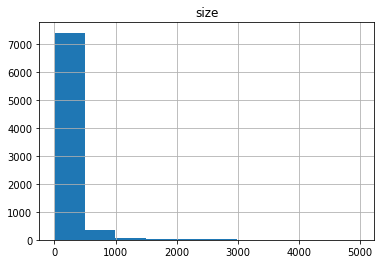

In [60]:
"""
We will now calculate some statistics to get an understanding of our dataset.
Here we look at some statistics about the size of the NEO's.
We can see that the standard deviation is pretty large compared to the man and average.
This can be realized in several ways, firstly one can see that the mean is way higher than the median indicating that the data contains some extremely large values.
Secondly one can see on the histogram that there is a lot of small asteroids and a few large ones. With regards to the distribution it seems fair to conclude that the distribution is exponential
"""

mean_size = basic_df["size"].mean()
median_size = basic_df["size"].median()
std_size = basic_df["size"].std()
print(mean_size, median_size, std_size)
basic_df.hist(column="size")


30549891.20394238 27501485.0 55.6599250072


array([[<AxesSubplot:title={'center':'closest_approach_distance'}>]],
      dtype=object)

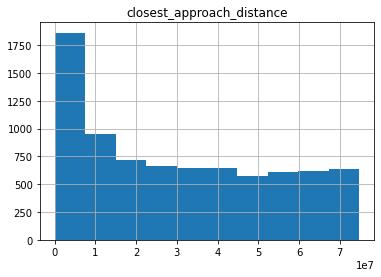

In [61]:
"""
Now we perform the same analysis with respect to the closest approach distance.
From both the plot and the standard deviation it can be seen that the average distance from the median is far smaller for this feature than the previous one.
Though NEO's passing within one million kilometers are more frequent than the other equally sized intervals it seems fair to conclude that there is a pretty uniform distribution amongst the observations with a skeewness towards the left.
"""
mean_dist = basic_df["closest_approach_distance"].mean()
median_dist = basic_df["closest_approach_distance"].median()
std_dist = basic_df["closest_approach_distance"].std()
print(mean_dist, median_dist, median_size)
basic_df.hist(column="closest_approach_distance")

In [70]:
"""
Now lets look at the correlation between the approach distance and the size of the NEO respectively, and whether or not the NEO is hazardous.
Though small there is a higher degree of correlation between the hazardousness and size of a NEO than there is between the hazardousness and approach distance. It makes sense that the larger an object is the more ammount of energy it carries, hence it poses a bigger threat.
We expect that the approach distance and the size of the object in combination can provide a greater degree of explanation which could be uncovered by using a linear regression model for example.
"""

corr_distance = basic_df["is_hazardous"].corr(basic_df["closest_approach_distance"])
corr_size = basic_df["is_hazardous"].corr(basic_df["size"])
print(corr_distance, corr_size)



0.09229697276500223 0.25651766620436917


### Task 3: Data Visualization Part A

- Create a line plot of the number of NEOs per week.
- Create a histogram of the distribution of NEO sizes.
- Create a bar plot of the average NEO size per week.
- Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. **Be creative**!

In [93]:
# Write your code
# get week from date
import datetime
basic_df["week"] = basic_df["date"].apply(lambda date : datetime.date(int(date[0:4]), int(date[5:7]), int(date[8:10])).isocalendar()[1])

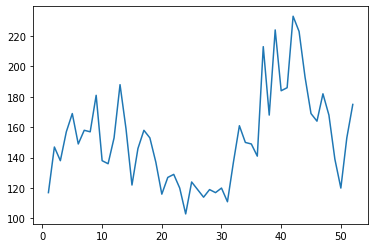

In [101]:
# lineplot showing NEO's for each week
"""
It can be seen that there has been a drop in the ammount of NEO's during the summer period.

The histogram which is part of this task has been created in the previous task

"""
import matplotlib.pyplot as plt

plt.plot([x for x in range(1,53)], basic_df.groupby("week")["date"].count().values)

<BarContainer object of 52 artists>

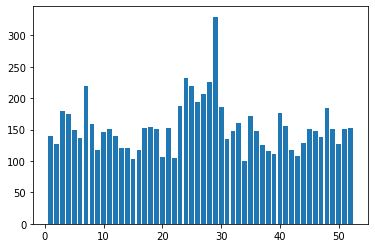

In [102]:
"""
Here we can see hte average size of the NEO's by each week.

Interestingly enough there seems to be a small tendency of observing larger NEO's during the summer where the amount of observations is smaller
"""
plt.bar([x for x in range(1,53)], basic_df.groupby("week")["size"].mean().values)

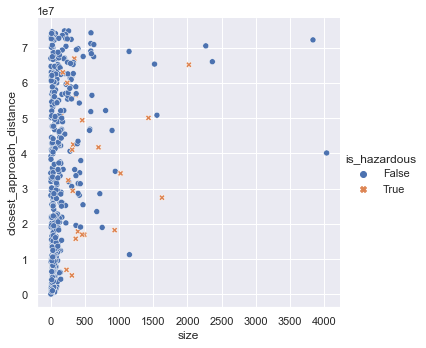

In [119]:
"""
As we discussed earlier it might be possible to better predict whether a NEO is hazardous or not if we factor in both the size and the approach distance.

To visualize this we have created these plots.
"""
import seaborn as sns

sample_size = 500
data_sample = basic_df.sample(sample_size)

sns.relplot(data= data_sample,
            x = "size", y = "closest_approach_distance", hue="is_hazardous", style="is_hazardous")



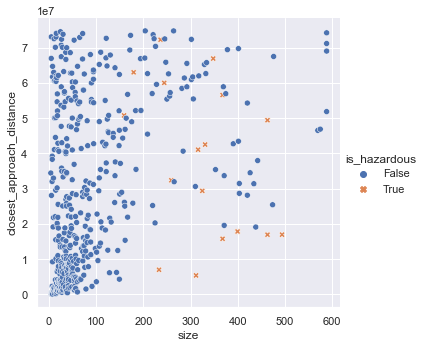

In [120]:
"""
It can be seen that some of the very large size values makes the chart a bit hard to read so in order to better gain an insight we will now filter out those.

When inspecting this plot is can be seen that the amount of hazardous NEO's does not really seem to change as the distance decreases, however as the size increases we find that more NEO's become hazardous. This seems to be in accordance with our previous analysis of the correlations between variables.

Another interesting finding in this char is that there seems to be a lower size threshold which NEO's must be greater than to be hazardous. Looking at the map it can be seen that no hazardous NEO's have size of less than 150 kilometers.
"""
data_sample = data_sample.nsmallest(int(sample_size*0.95), "size")
sns.relplot(data= data_sample,
            x = "size", y = "closest_approach_distance", hue="is_hazardous", style="is_hazardous")

### Task 4: Data Visualization Part B

- Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.
- Create a scatter plot of the correlation between NEO size and close approach distance.
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

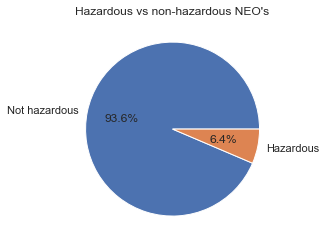

In [146]:
# Write your code

"""
Here we see that about 6.4% of all the asteroid in our dataset is considered hazardous.
"""
fig, ax = plt.subplots()
ax.pie(basic_df.groupby("is_hazardous")["is_hazardous"].count().values, labels=[ "Not hazardous", "Hazardous"], autopct='%1.1f%%')
ax.title.set_text("Hazardous vs non-hazardous NEO's")

[Text(0.5, 1.0, 'Scatter plot of Size vs Closest Approach Distanced')]

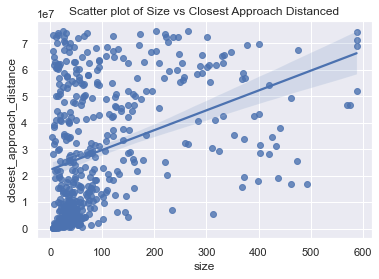

In [148]:
"""
Here we have tried to create a scatter plot with a regression line, however due to the nonlinear relation between approach distance and size the line is not that predictive. We conclude that no clear connection between size and closest approach distance exists.
"""
sns.regplot(x=data_sample["size"], y=data_sample["closest_approach_distance"]).set(title="Scatter plot of Size vs Closest Approach Distanced")

In [171]:
"""
Another relevant factor when determining if a NEO is hazardous or not is the speed of which it is moving relatively to the earth or whatever celestial body it is orbiting.

To give provide an insight to this matter we have created this plotly chart showing the hazardousness against size and velocity.

As discussed earlier there seems to be a critical size which a NEO much have to be hazardous this line can be seen as a vertical line to the immediate left of the first red points.

Once again it seems that size is the predominant factor in determining whether a NEO is hazardous or not, this conclusion is based upon the lack of a clear tendency showing an increase hazardousness as velocity increases.
"""

#here we add velocity to the dataframe

velocity = [neo["close_approach_data"][0]["relative_velocity"]["kilometers_per_hour"] for neo in concat_data]
basic_df["velocity"] = velocity

# Here we add the name of the NEO

name = [neo["name"] for neo in concat_data]
basic_df["name"] = name

In [172]:
import plotly.express as px
sample = basic_df.sample(500).sort_values("velocity")
sample["velocity"] = sample["velocity"].apply(lambda x : int(float(x)))
# we use a log scale on the x-axis such that it is easier to see the different points
fig = px.scatter(sample, x="size", y ="velocity", log_x=True, color="is_hazardous", title="Scatter plot of velocity and size", hover_name= "name")

fig.show()

### Task 5: Interpretation of Results

- Interpret the results of your data visualization in part A and B.
- What insights can you gain about NEOs from your results? Summarizing your findings.
- Use your findings to make predictions or recommendations. For example, if you found that larger NEOs are more likely to be potentially hazardous, you could recommend that more resources be allocated to tracking large NEOs. **Be creative!**
- Identify, understand, and explain one scientific paper, on a clustering or classification method of relevance that could help Task 5. You don't have to implement it, you just need to justify in this notebook why the method in the scientific paper could contribute in analysis or interpretation of the results.

In [ ]:
# Write your code
"""

From our analysis and visulazations we find that the predominant factor in determining the hazardousness of a NEO is the size of it. The conclusion is reached since there seems to be no clear pattern nor statistical parameter suggesting that neither velocity nor the closest approach distance should be a driving factor. When inspecting the impact of size it can be seen that all hazardous NEOS have a size greater than 150 km, we suggest this value as a critical value in the dataset meaning that NEOs with a smaller size will not be considered hazardous.

The above mentioned conclusion are drawn by inspecting our plot and seen that the linear regression line is not that predictive at all.

As a general rule NEOs smaller than 150 km in diameter are not dangerous and should therefore not be tracked with great care, while NEOs above this threshold regularly poses and dangerous, hence they should be monitored more closely.


We have found this research paper that we find interesting: https://dl.acm.org/doi/pdf/10.1145/304182.304187

It describes the OPTICS clustering algorithm which is a density based algorithm, however it instead of creating a result in the form of the given clusters it returns what the authors call an augmented clustering order database. This is a way to store the information which is much more flexible and configurable compared to other density based algorithms. We find that this could be great to use if we had to conduct further analysis in this field since we get the ability to create fast and interactive models where we can try adding new parameters to the clustering algorithm. In this way we will be able to include more features in analysis which could lead to a higher accuracy. Even though this paper is a little old we think that it could still be useful

"""

### Task 6: Presentation and Documentation

- Make this project as part of your presentation, **using beamer in LaTeX**.
- This should include an overview of your work, the results of your data analysis, and the insights you gained from your results.